In [ ]:
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 102.5 MB/s eta 0:00:00


# DWI

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/Final_DWI.csv"
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE
TEST_SPLIT_RATIO = 0.2
RANDOM_STATE = 42
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
L2_REG_STRENGTH = 1e-4
DROPOUT_DENSE = 0.5

import pandas as pd
import numpy as np

# Configuration
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/Final_DWI.csv"
N_FEATURES = 6724

# Data Loading
print("Loading data...")
try:
    df = pd.read_csv(FILE_PATH, header=None)
    print(f"DataFrame loaded shape (before .values): {df.shape}")

    data_all = df.values

    # the structure is: [ID, Feature1, ..., Feature6724, Label]
    # Total columns = 1 (ID) + 6724 (Features) + 1 (Label) = 6726 columns

    num_expected_cols = 1 + N_FEATURES + 1
    if data_all.shape[1] != num_expected_cols:
        print(f"Warning: Expected {num_expected_cols} columns, but found {data_all.shape[1]}. Adjusting slicing based on shape.")
        # Flexible slicing based on shape - ID is first, Label is last
        if data_all.shape[1] >= 2:
             raw_ids_col = data_all[:, 0]            # ID: First column
             X_dwi_flat = data_all[:, 1:-1].astype(np.float32) # Features: Skip first, skip last
             y_labels = data_all[:, -1].astype(np.int64)   # Label: Last column
        else:
             raise ValueError("Loaded data has fewer than 2 columns. Cannot extract ID, Features, Label.")
    else:
        # standard slicing if shape matches expected
        raw_ids_col = data_all[:, 0]            # ID: First column
        X_dwi_flat = data_all[:, 1:1+N_FEATURES].astype(np.float32) # Features: Col 1 up to N_FEATURES+1
        y_labels = data_all[:, -1].astype(np.int64)   # Label: Last column

    print(f"Data loaded successfully. X shape: {X_dwi_flat.shape}, y shape: {y_labels.shape}, IDs shape: {raw_ids_col.shape}")

    # Post-Load Checks
    if X_dwi_flat.shape[0] != y_labels.shape[0] or X_dwi_flat.shape[0] != raw_ids_col.shape[0]:
         raise ValueError("Mismatch in number of rows between loaded IDs, features, and labels.")
    if X_dwi_flat.shape[0] != 787:
         print(f"Warning: Loaded {X_dwi_flat.shape[0]} rows, but expected 787 based on fMRI count.")
    if X_dwi_flat.shape[1] != N_FEATURES:
        raise ValueError(f"Error: Extracted features shape is {X_dwi_flat.shape[1]}, but expected {N_FEATURES}.")

except FileNotFoundError:
    print(f"Error: File not found at {FILE_PATH}")
    raise SystemExit("Data loading failed.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    raise SystemExit("Data loading failed.")

Loading data...
DataFrame loaded shape (before .values): (787, 6726)
Data loaded successfully. X shape: (787, 6724), y shape: (787,), IDs shape: (787,)


Preprocessing data...
Train set: (629, 82, 82, 1), Test set: (158, 82, 82, 1)
Building the MILDLY regularized CNN model (L2 only)...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 82, 82, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 82, 82, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 41, 41, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 41, 41, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 41, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 843,713 (3.22 MB)

 Trainable params: 843,233 (3.22 MB)

 Non-trainable params: 480 (1.88 KB)

Compiling the model...
Calculated Class Weights: {0: np.float64(0.9037356321839081), 1: np.float64(1.1192170818505338)}
Setting up callbacks...
Starting model training...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6171 - auc: 0.6604 - loss: 0.8497 - precision: 0.5686 - recall: 0.6760
Epoch 1: val_loss improved from inf to 0.67054, saving model to best_dwi_l2_cnn_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 527ms/step - accuracy: 0.6197 - auc: 0.6640 - loss: 0.8450 - precision: 0.5710 - recall: 0.6779 - val_accuracy: 0.6947 - val_auc: 0.8239 - val_loss: 0.6705 - val_precision: 0.5932 - val_recall: 0.8750
Epoch 2/100
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7876 - auc: 0.9019 - loss: 0.4302 - precision: 0.7828 - recall: 0.8035 
Epoch 2: val_loss improved from 0.67054 to 0.66896, saving model to best_dwi_l2_cnn_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7867 - auc: 0.8967 - loss: 0.4423 - precision: 0.7568 - recall: 0.8193 - val_acc

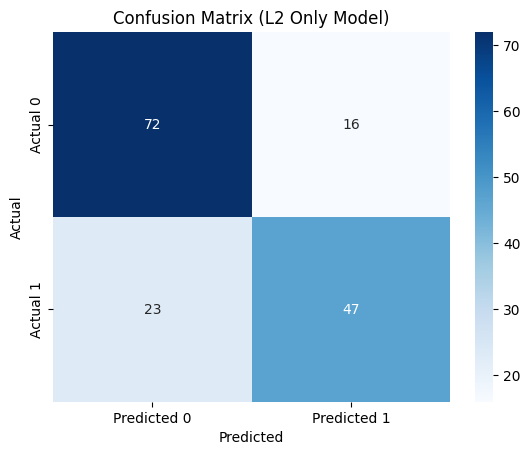


Plotting training history...

--- DWI L2 Only Model Script Finished ---


In [ ]:
print("Preprocessing data...")
X_train_flat, X_test_flat, y_train, y_test = train_test_split(
    X_dwi_flat, y_labels, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_labels)
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_train_reshaped = X_train_scaled_flat.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_reshaped = X_test_scaled_flat.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(f"Train set: {X_train_reshaped.shape}, Test set: {X_test_reshaped.shape}")


# 3. Defining Mildly Regularized 2D CNN Model
print("Building the MILDLY regularized CNN model (L2 only)...")

def build_l2_cnn_model(input_shape):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),

            # Convolutional Block 1
            layers.Conv2D(
                16, kernel_size=(3, 3), activation="relu", padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH)
            ),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            # NO Dropout

            # Convolutional Block 2
            layers.Conv2D(
                32, kernel_size=(3, 3), activation="relu", padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH)
            ),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            # NO Dropout

            # Convolutional Block 3
            layers.Conv2D(
                64, kernel_size=(3, 3), activation="relu", padding="same",
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH)
            ),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2, 2)),
            # NO Dropout

            # Classifier Head
            layers.Flatten(),
            layers.Dense(
                128, activation="relu",
                kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH)
                ),
            layers.BatchNormalization(),
            layers.Dropout(DROPOUT_DENSE), # FINAL dropout
            layers.Dense(1, activation="sigmoid"), # Output layer
        ]
    )
    return model

model = build_l2_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.summary()

# 4. Compile Model
print("Compiling the model...")
metrics = [
    'accuracy',
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=metrics
)

# 5. Class Weights
unique_classes = np.unique(y_train)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=unique_classes,
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print(f"Calculated Class Weights: {class_weights_dict}")

# 6. Callbacks
print("Setting up callbacks...")
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_dwi_l2_cnn_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# 7. Train the Model
print("Starting model training...")
history = model.fit(
    X_train_reshaped,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.15,
    callbacks=[early_stopping, model_checkpoint],
    class_weight=class_weights_dict,
    verbose=1
)
print("Training finished.")

# 8. Evaluate the Model
print("\nEvaluating the best L2 ONLY model on the test set...")
print("Loading best weights saved during training...")
try:
    best_model = tf.keras.models.load_model('best_dwi_l2_cnn_model.keras')
except Exception as e:
    print(f"Could not load saved L2 model, using the model from the end of training. Error: {e}")
    best_model = model

test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(
    X_test_reshaped, y_test, verbose=0
)

print("\nTest Set Performance (L2 Only Model):")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  AUC:       {test_auc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")

y_pred_proba = best_model.predict(X_test_reshaped).flatten()
y_pred_classes = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report (L2 Only Model):")
print(classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1']))

print("\nConfusion Matrix (L2 Only Model):")
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (L2 Only Model)')
plt.show()

# 9. Plot Training History
print("\nPlotting training history...")

print("\n--- DWI L2 Only Model Script Finished ---")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import re # for ID extraction
import gc

# Configuration (Matching the L2 Only run)
FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/Final_DWI.csv"
SAVED_MODEL_PATH = 'best_dwi_l2_cnn_model.keras'
FEATURE_OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
BATCH_SIZE = 32 # Batch size for predict
LEARNING_RATE = 1e-4
L2_REG_STRENGTH = 1e-4
DROPOUT_DENSE = 0.5
FEATURE_LAYER_NAME = 'feature_dense'

# Define Mildly Regularized 2D CNN Model using FUNCTIONAL API

def build_functional_l2_cnn_model(input_shape):
    inputs = keras.Input(shape=input_shape, name="input_image")
    x = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(inputs)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(x)
    x = layers.BatchNormalization()(x); x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    feature_output = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name=FEATURE_LAYER_NAME)(x)
    x = layers.BatchNormalization()(feature_output); x = layers.Dropout(DROPOUT_DENSE)(x)
    classifier_output = layers.Dense(1, activation="sigmoid", name='classifier_output')(x)
    model = keras.Model(inputs=inputs, outputs=classifier_output, name="functional_cnn")
    return model

# 1. Load All Data
print("Loading data...")
try:
    df = pd.read_csv(FILE_PATH, header=None)
    print(f"DataFrame loaded shape (before .values): {df.shape}")
    data_all = df.values
    num_expected_cols = 1 + N_FEATURES + 1
    if data_all.shape[1] != num_expected_cols:
        print(f"Warning: Expected {num_expected_cols} columns, found {data_all.shape[1]}. Using flexible slicing.")
        if data_all.shape[1] >= 2:
             raw_ids_col = data_all[:, 0]
             X_dwi_flat = data_all[:, 1:-1].astype(np.float32)
             y_labels = data_all[:, -1].astype(np.int64)
        else: raise ValueError("Loaded data has fewer than 2 columns.")
    else:
        raw_ids_col = data_all[:, 0]
        X_dwi_flat = data_all[:, 1:1+N_FEATURES].astype(np.float32)
        y_labels = data_all[:, -1].astype(np.int64)

    print(f"Data loaded successfully. X shape: {X_dwi_flat.shape}, y shape: {y_labels.shape}, IDs shape: {raw_ids_col.shape}")
    # Post-Load Checks
    if not (X_dwi_flat.shape[0] == y_labels.shape[0] == raw_ids_col.shape[0]):
         raise ValueError("Mismatch in number of rows between loaded IDs, features, and labels.")
    if X_dwi_flat.shape[1] != N_FEATURES:
        raise ValueError(f"Error: Extracted features shape is {X_dwi_flat.shape[1]}, expected {N_FEATURES}.")
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    raise SystemExit("Data loading failed.")

# 2. Recreate Original Train/Test Split
print("Recreating original train/test split...")

X_train_flat_orig, _, y_train_orig, _ = train_test_split(
    X_dwi_flat, y_labels, # Using loaded data
    test_size=TEST_SPLIT_RATIO,
    random_state=RANDOM_STATE,
    stratify=y_labels # Using loaded data
)

# 3. Preprocessing
print("Fitting scaler and transforming all data...")
scaler = StandardScaler()
scaler.fit(X_train_flat_orig) # Fitting on correct training split portion
X_scaled_flat_all = scaler.transform(X_dwi_flat) # Transforming the full loaded data

# 4. Reshape ALL Data
print("Reshaping all data...")
X_reshaped_all = X_scaled_flat_all.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(f"Reshaped data for feature extraction: {X_reshaped_all.shape}")

# 5. Build the Functional Model Architecture
print("Building functional model architecture...")
input_shape = (IMG_SIZE, IMG_SIZE, 1)
full_model = build_functional_l2_cnn_model(input_shape)
# full_model.summary()

# 6. Load Weights
print(f"Loading weights from {SAVED_MODEL_PATH}...")
try:
    full_model.load_weights(SAVED_MODEL_PATH)
    print("Model weights loaded successfully.")
except Exception as e:
    print(f"Error loading model weights: {e}")
    raise SystemExit("Model loading failed.")

# 7. Create Feature Extractor Model
print(f"Creating feature extractor model ending at layer: '{FEATURE_LAYER_NAME}'")
try:
    feature_layer_output = full_model.get_layer(FEATURE_LAYER_NAME).output
    feature_extractor_model = keras.Model(
        inputs=full_model.input,
        outputs=feature_layer_output,
        name="feature_extractor"
    )
    # feature_extractor_model.summary()
except Exception as e:
    print(f"Error creating feature extractor model: {e}")
    raise SystemExit("Feature extractor creation failed.")

# 8. Extract Features
print("Extracting features for all samples...")
extracted_features = feature_extractor_model.predict(X_reshaped_all, batch_size=BATCH_SIZE)
print(f"Features extracted. Shape: {extracted_features.shape}")

# 9. Standardize IDs
print("Standardizing IDs...")
def extract_subject_id(raw_id):
    raw_id_str = str(raw_id)
    match = re.search(r'(\d{6})', raw_id_str)
    if match:
        return match.group(1)
    else:
        # extracting if format is just the number already (from fMRI filename based ID)
        match_simple = re.fullmatch(r'(\d{6})', raw_id_str)
        if match_simple:
            return match_simple.group(1)
        print(f"Warning: Could not extract 6-digit ID from '{raw_id_str}'. Using raw value.")
        return raw_id_str

standardized_ids = [extract_subject_id(raw_id) for raw_id in raw_ids_col]

if len(standardized_ids) != extracted_features.shape[0]:
     raise ValueError(f"Mismatch between # standardized IDs ({len(standardized_ids)}) and # features ({extracted_features.shape[0]})")


# 10. Save Features
print(f"Saving features to {FEATURE_OUTPUT_PATH}...")
features_with_labels = np.hstack((np.array(standardized_ids).reshape(-1, 1), extracted_features, y_labels.reshape(-1, 1)))

feature_columns = [f'dwi_feature_{i+1}' for i in range(extracted_features.shape[1])]
column_names = ['SubjectID'] + feature_columns + ['label']
features_df = pd.DataFrame(features_with_labels, columns=column_names)
features_df['label'] = features_df['label'].astype(int)

try:
    features_df.to_csv(FEATURE_OUTPUT_PATH, index=False)
    print("Features saved successfully with Standardized IDs.")
except Exception as e:
    print(f"Error saving features: {e}")

print("\n--- DWI Feature Extraction Script Finished ---")
gc.collect()

Loading data...
DataFrame loaded shape (before .values): (787, 6726)
Data loaded successfully. X shape: (787, 6724), y shape: (787,), IDs shape: (787,)
Recreating original train/test split...
Fitting scaler and transforming all data...
Reshaping all data...
Reshaped data for feature extraction: (787, 82, 82, 1)
Building functional model architecture...
Loading weights from best_dwi_l2_cnn_model.keras...
Model weights loaded successfully.
Creating feature extractor model ending at layer: 'feature_dense'
Extracting features for all samples...
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Features extracted. Shape: (787, 128)
Standardizing IDs...
Saving features to /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv...
Features saved successfully with Standardized IDs.

--- DWI Feature Extraction Script Finished ---


5839

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import os
import numpy as np
import pandas as pd
# Data loading/processing specific imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
# XGBoost specific import
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Configuration
FOLDER_PATH_F = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy" # Female fMRI matrices
FOLDER_PATH_M = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy" # Male fMRI matrices
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE # 6724
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
EPOCHS = 120
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
L2_REG_STRENGTH = 1e-4 # From best DWI model
DROPOUT_DENSE = 0.5   # From best DWI model
FEATURE_LAYER_NAME = 'feature_dense_fmri'

# 1. Load fMRI Data
print("Loading fMRI data...")

def load_matrix(file_path):
    """Loading a matrix from a CSV file, applying specific slicing and cleaning."""
    try:
        df = pd.read_csv(file_path, header=None)

        # slicing logic
        # data is in rows 1+ and columns 1-82
        df_sliced = df.iloc[1:, 1:83]

        # Checking dimensions after slicing
        if df_sliced.shape != (IMG_SIZE, IMG_SIZE):
             print(f"Warning: Sliced shape is {df_sliced.shape} for file {os.path.basename(file_path)}. Expected ({IMG_SIZE}, {IMG_SIZE}). Check slicing logic.")

        # Converting to numeric, coerce errors, fill NaN
        df_numeric = df_sliced.apply(pd.to_numeric, errors='coerce')
        nan_count = df_numeric.isna().sum().sum()
        if nan_count > 0:
            # Only printing if NaNs were actually found and filled
            print(f"  File: {os.path.basename(file_path)}, NaN count filled: {nan_count}")
        df_filled = df_numeric.fillna(0)

        return df_filled.to_numpy().flatten() # Flatten the 82x82 matrix

    except FileNotFoundError:
        print(f"Error: File not found {file_path}")
        return None
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

data_list = []
labels = []
subject_ids = [] # to keep track of filenames/IDs

# Processing M folder first (label 1)
print(f"\nProcessing Male folder: {FOLDER_PATH_M}")
file_list_m = sorted([f for f in os.listdir(FOLDER_PATH_M) if f.endswith(".csv")])
print(f"Found {len(file_list_m)} male files.")
for file in file_list_m:
    file_path = os.path.join(FOLDER_PATH_M, file)
    matrix = load_matrix(file_path)
    if matrix is not None and matrix.shape[0] == N_FEATURES:
        data_list.append(matrix)
        labels.append(1)
        subject_ids.append(os.path.splitext(file)[0]) # Storing filename without extension as ID
    elif matrix is not None:
         print(f"Skipping file {file} due to incorrect feature count ({matrix.shape[0]} != {N_FEATURES}) after flatten.")

# Processing F folder second (label 0)
print(f"\nProcessing Female folder: {FOLDER_PATH_F}")
file_list_f = sorted([f for f in os.listdir(FOLDER_PATH_F) if f.endswith(".csv")])
print(f"Found {len(file_list_f)} female files.")
for file in file_list_f:
    file_path = os.path.join(FOLDER_PATH_F, file)
    matrix = load_matrix(file_path)
    if matrix is not None and matrix.shape[0] == N_FEATURES:
        data_list.append(matrix)
        labels.append(0)
        subject_ids.append(os.path.splitext(file)[0])
    elif matrix is not None:
         print(f"Skipping file {file} due to incorrect feature count ({matrix.shape[0]} != {N_FEATURES}) after flatten.")

# Converting to NumPy arrays
X_fmri_flat_all = np.array(data_list, dtype=np.float32)
y_fmri_labels_all = np.array(labels, dtype=np.int64)
subject_ids_all = np.array(subject_ids)

print(f"\nData loading complete.")
print(f"Features shape: {X_fmri_flat_all.shape}")
print(f"Labels shape: {y_fmri_labels_all.shape}")
print(f"Label distribution: {np.bincount(y_fmri_labels_all)}")
# Basic check
if X_fmri_flat_all.shape[0] != len(y_fmri_labels_all):
     raise SystemExit("Error: Mismatch between number of samples in features and labels after loading.")
if X_fmri_flat_all.shape[0] == 0:
     raise SystemExit("Error: No data loaded successfully. Check paths and file contents.")

Loading fMRI data...

Processing Male folder: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy
Found 351 male files.

Processing Female folder: /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy
Found 436 female files.

Data loading complete.
Features shape: (787, 6724)
Labels shape: (787,)
Label distribution: [436 351]


In [ ]:
import os
import numpy as np
import pandas as pd
# Data loading/processing specific imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
# XGBoost specific import
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import gc

IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
# XGBoost Specific Params
N_ESTIMATORS = 500 # Number of trees (boosting rounds)
MAX_DEPTH = 6      # Max depth of each tree
LEARNING_RATE = 0.05 # Step size shrinkage
SUBSAMPLE = 0.8    # Fraction of samples used per tree
COLSAMPLE_BYTREE = 0.8 # Fraction of features used per tree
EARLY_STOPPING_ROUNDS = 30 # Stop point if eval metric doesn't improve for this many rounds

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Configuration
FOLDER_PATH_F = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy"
FOLDER_PATH_M = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy"
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
EPOCHS = 150
BATCH_SIZE = 32
# Hyperparameter Tuning
LEARNING_RATE = 5e-5
L2_REG_STRENGTH = 5e-4
DROPOUT_DENSE = 0.65
PATIENCE_EARLY_STOP = 30
PATIENCE_LR_SCHED = 12

FEATURE_LAYER_NAME = 'fmri_tuned_feature_dense'
MODEL_SAVE_PATH = 'best_fmri_tuned_l2_cnn_model.keras'

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Configuration
FOLDER_PATH_F = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy"
FOLDER_PATH_M = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy"
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
EPOCHS = 120
BATCH_SIZE = 32
# Hyperparameters
LEARNING_RATE = 1e-4
L2_REG_STRENGTH = 1e-4
DROPOUT_DENSE = 0.5
PATIENCE_EARLY_STOP = 25 # Moderate patience
PATIENCE_LR_SCHED = 10

FEATURE_LAYER_NAME = 'fmri_gap_feature_dense'
MODEL_SAVE_PATH = 'best_fmri_gap_cnn_model.keras'


Preprocessing fMRI data...
Train set: (629, 82, 82, 1), Test set: (158, 82, 82, 1)

Building the fMRI CNN model with GlobalAveragePooling...


Model: "fmri_gap_functional_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 82, 82, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 82, 82, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 82, 82, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 41, 41, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 41, 41, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fmri_gap_feature_dense (Dense)  │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_output (Dense)       │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,705 (127.75 KB)

 Trainable params: 32,225 (125.88 KB)

 Non-trainable params: 480 (1.88 KB)


Compiling the GAP fMRI model...
Calculating class weights...
Calculated Class Weights for fMRI: {0: np.float64(0.9037356321839081), 1: np.float64(1.1192170818505338)}
Setting up callbacks...

Starting GAP fMRI model training...
Epoch 1/120
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5550 - auc: 0.5869 - loss: 0.7835 - precision: 0.5104 - recall: 0.5877
Epoch 1: val_loss improved from inf to 0.70350, saving model to best_fmri_gap_cnn_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 370ms/step - accuracy: 0.5554 - auc: 0.5877 - loss: 0.7830 - precision: 0.5104 - recall: 0.5870 - val_accuracy: 0.5570 - val_auc: 0.5935 - val_loss: 0.7035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/120
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5882 - auc: 0.6318 - loss: 0.7669 - precision: 0.5004 - recall: 0.6432
Epoch 2: val_loss did not improve from 0.70350
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5971 - auc: 0.6402 - loss: 0.7555 

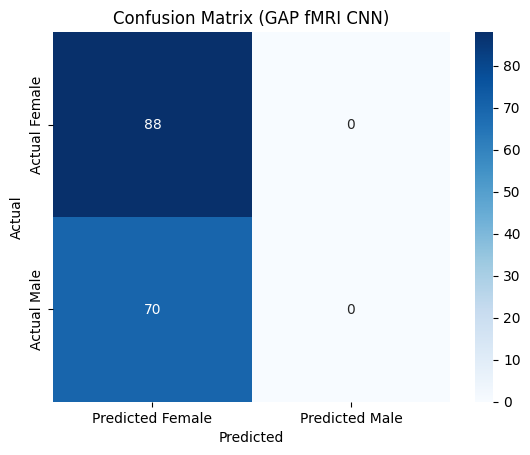

In [ ]:
print("\nPreprocessing fMRI data...")
X_train_flat, X_test_flat, y_train, y_test = train_test_split(
    X_fmri_flat_all, y_fmri_labels_all, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_fmri_labels_all)
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_test_scaled_flat = scaler.transform(X_test_flat)
X_train_reshaped = X_train_scaled_flat.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test_reshaped = X_test_scaled_flat.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(f"Train set: {X_train_reshaped.shape}, Test set: {X_test_reshaped.shape}")

# 3. Defining CNN Model with GlobalAveragePooling
print("\nBuilding the fMRI CNN model with GlobalAveragePooling...")

def build_gap_functional_cnn(input_shape):
    inputs = keras.Input(shape=input_shape, name="input_image")
    # Block 1
    x = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Block 2
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Block 3
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Classifier Head
    x = layers.GlobalAveragePooling2D()(x)
    # Adding Dense layer after GAP before final dropout: can learn combinations of the averaged filter responses
    feature_output = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name=FEATURE_LAYER_NAME)(x)
    x = layers.BatchNormalization()(feature_output)
    x = layers.Dropout(DROPOUT_DENSE)(x)
    classifier_output = layers.Dense(1, activation="sigmoid", name='classifier_output')(x)
    model = keras.Model(inputs=inputs, outputs=classifier_output, name="fmri_gap_functional_cnn")
    return model

fmri_model_gap = build_gap_functional_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 1))
fmri_model_gap.summary()

# 4. Compile Model
print("\nCompiling the GAP fMRI model...")
metrics = ['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
fmri_model_gap.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=metrics)

# 5. Class Weights
print("Calculating class weights...")
unique_classes = np.unique(y_train)
class_weights_fmri = class_weight.compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict_fmri = dict(enumerate(class_weights_fmri))
print(f"Calculated Class Weights for fMRI: {class_weights_dict_fmri}")

# 6. Callbacks
print("Setting up callbacks...")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_EARLY_STOP, restore_best_weights=True, verbose=1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=PATIENCE_LR_SCHED, min_lr=1e-6, verbose=1)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)

# 7. Train the Model
print("\nStarting GAP fMRI model training...")
tf.keras.backend.clear_session()
gc.collect()

history_gap = fmri_model_gap.fit(
    X_train_reshaped, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stopping, lr_scheduler, model_checkpoint],
    class_weight=class_weights_dict_fmri,
    verbose=1
)
print("Training finished. Best model potentially saved to", MODEL_SAVE_PATH)

# 8. Evaluate the Model
print("\nEvaluating the GAP fMRI model on the test set...")
try:
    best_gap_model = tf.keras.models.load_model(MODEL_SAVE_PATH)
    print("Best GAP model loaded successfully.")
except Exception as e:
    print(f"Could not load saved GAP model from {MODEL_SAVE_PATH}. Error: {e}")
    best_gap_model = fmri_model_gap # Fallback

test_loss, test_accuracy, test_auc, test_precision, test_recall = best_gap_model.evaluate(
    X_test_reshaped, y_test, verbose=0)

print("\nTest Set Performance (GAP fMRI CNN Model):")
print(f"  Loss:      {test_loss:.4f}")
print(f"  Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  AUC:       {test_auc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
y_pred_proba = best_gap_model.predict(X_test_reshaped).flatten()
y_pred_classes = (y_pred_proba > 0.5).astype(int)
test_f1 = f1_score(y_test, y_pred_classes, zero_division=0)
print(f"  F1-Score:  {test_f1:.4f}")
print("\nClassification Report (GAP fMRI CNN Model):")
print(classification_report(y_test, y_pred_classes, target_names=['Female (0)', 'Male (1)'], zero_division=0))
print("\nConfusion Matrix (GAP fMRI CNN Model):")
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Female', 'Predicted Male'], yticklabels=['Actual Female', 'Actual Male'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (GAP fMRI CNN)')
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Configuration
FOLDER_PATH_F = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy"
FOLDER_PATH_M = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy"
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
EPOCHS = 120
BATCH_SIZE = 32
# Hyperparameters
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
L2_REG_STRENGTH = 1e-4
DROPOUT_DENSE = 0.5
PATIENCE_EARLY_STOP = 25
PATIENCE_LR_SCHED = 10

FEATURE_LAYER_NAME = 'fmri_gap_filters_feature_dense'
MODEL_SAVE_PATH = 'best_fmri_gap_filters_cnn_model.keras'

In [ ]:
# PHASE 1: Extracting fMRI features using the GAP CNN model

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc

# Configuration
FOLDER_PATH_F = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fcopy"
FOLDER_PATH_M = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/mcopy"

SAVED_MODEL_PATH = 'best_fmri_gap_cnn_model.keras'
FEATURE_OUTPUT_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
IMG_SIZE = 82
N_FEATURES = IMG_SIZE * IMG_SIZE
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2

FEATURE_LAYER_NAME = 'fmri_gap_feature_dense'
# Model Hyperparameters
L2_REG_STRENGTH = 1e-4
DROPOUT_DENSE = 0.5

# Defining GAP CNN Model
print("Defining GAP CNN model architecture for loading...")
def build_gap_functional_cnn(input_shape):
    inputs = keras.Input(shape=input_shape, name="input_image")
    # Block 1
    x = layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Block 2
    x = layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Block 3
    x = layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    # Classifier Head
    x = layers.GlobalAveragePooling2D()(x)
    # Named Layer
    feature_output = layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(L2_REG_STRENGTH), name=FEATURE_LAYER_NAME)(x)
    x = layers.BatchNormalization()(feature_output)
    x = layers.Dropout(DROPOUT_DENSE)(x)
    classifier_output = layers.Dense(1, activation="sigmoid", name='classifier_output')(x)
    model = keras.Model(inputs=inputs, outputs=classifier_output, name="fmri_gap_functional_cnn")
    return model

# 1. Load fMRI Data
print("Loading fMRI data...")

if 'X_fmri_flat_all' not in locals() or 'y_fmri_labels_all' not in locals() or 'subject_ids_all' not in locals():
     print("Reloading fMRI data...")
     def load_matrix(file_path):
         try:
             df = pd.read_csv(file_path, header=None); df_sliced = df.iloc[1:, 1:83]
             if df_sliced.shape != (IMG_SIZE, IMG_SIZE): print(f"Warning: Sliced shape {df_sliced.shape} for {os.path.basename(file_path)}.")
             df_numeric = df_sliced.apply(pd.to_numeric, errors='coerce'); df_filled = df_numeric.fillna(0)
             return df_filled.to_numpy().flatten()
         except Exception as e: print(f"Error processing file {file_path}: {e}"); return None
     data_list = []; labels = []; subject_ids = []
     print(f"\nProcessing M: {FOLDER_PATH_M}"); file_list_m = sorted([f for f in os.listdir(FOLDER_PATH_M) if f.endswith(".csv")])
     for file in file_list_m:
         file_path = os.path.join(FOLDER_PATH_M, file); matrix = load_matrix(file_path)
         if matrix is not None and matrix.shape[0] == N_FEATURES: data_list.append(matrix); labels.append(1); subject_ids.append(os.path.splitext(file)[0])
         elif matrix is not None: print(f"Skipping M file {file}.")
     print(f"\nProcessing F: {FOLDER_PATH_F}"); file_list_f = sorted([f for f in os.listdir(FOLDER_PATH_F) if f.endswith(".csv")])
     for file in file_list_f:
         file_path = os.path.join(FOLDER_PATH_F, file); matrix = load_matrix(file_path)
         if matrix is not None and matrix.shape[0] == N_FEATURES: data_list.append(matrix); labels.append(0); subject_ids.append(os.path.splitext(file)[0])
         elif matrix is not None: print(f"Skipping F file {file}.")
     X_fmri_flat_all = np.array(data_list, dtype=np.float32); y_fmri_labels_all = np.array(labels, dtype=np.int64); subject_ids_all = np.array(subject_ids)
     print(f"\nLoad complete. Features: {X_fmri_flat_all.shape}, Labels: {y_fmri_labels_all.shape}")
     if X_fmri_flat_all.shape[0] == 0: raise SystemExit("Error: No fMRI data loaded.")


# 2. Recreating Original Split for Scaler
print("Recreating original train/test split...")
X_train_flat_orig, _, y_train_orig, _ = train_test_split(
    X_fmri_flat_all, y_fmri_labels_all, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_fmri_labels_all)

# 3. Preprocessing (Fit scaler on orig train, transform all)
print("Fitting scaler and transforming all data...")
scaler_fmri = StandardScaler()
scaler_fmri.fit(X_train_flat_orig)
X_scaled_flat_all = scaler_fmri.transform(X_fmri_flat_all)

# 4. Reshape ALL Data
print("Reshaping all data...")
X_reshaped_all = X_scaled_flat_all.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(f"Reshaped data for feature extraction: {X_reshaped_all.shape}")

# 5. Load the Trained GAP fMRI CNN Model
print(f"Loading trained GAP fMRI model from {SAVED_MODEL_PATH}...")
try:
    full_model_fmri = tf.keras.models.load_model(SAVED_MODEL_PATH)
    print("GAP fMRI Model loaded successfully.")
    # full_model_fmri.summary()
except Exception as e:
    print(f"Error loading model: {e}")
    print(f"Make sure the file '{SAVED_MODEL_PATH}' exists and corresponds to the GAP CNN run.")
    raise SystemExit("Model loading failed.")

# 6. Create Feature Extractor Model
print(f"Creating fMRI feature extractor model ending at layer: '{FEATURE_LAYER_NAME}'")
try:
    feature_layer_output = full_model_fmri.get_layer(FEATURE_LAYER_NAME).output
    feature_extractor_model_fmri = keras.Model(
        inputs=full_model_fmri.input,
        outputs=feature_layer_output,
        name="fmri_feature_extractor"
    )
    # feature_extractor_model_fmri.summary()
except Exception as e:
    print(f"Error creating fMRI feature extractor model: {e}")
    print(f"Ensure the layer name '{FEATURE_LAYER_NAME}' exists in the loaded model.")
    raise SystemExit("Feature extractor creation failed.")

# 7. Extract Features
print("Extracting fMRI features for all samples...")
BATCH_SIZE = 32
extracted_fmri_features = feature_extractor_model_fmri.predict(X_reshaped_all, batch_size=BATCH_SIZE)
print(f"fMRI features extracted. Shape: {extracted_fmri_features.shape}")

# 8. Save Features
print(f"Saving fMRI features to {FEATURE_OUTPUT_PATH}...")
print("Standardizing fMRI IDs...")
def extract_subject_id(raw_id):
    raw_id_str = str(raw_id)
    match = re.search(r'(\d{6})', raw_id_str)
    if match: return match.group(1)
    else: print(f"Warning: Could not extract 6-digit ID from '{raw_id_str}'. Using raw."); return raw_id_str

standardized_ids_fmri = [extract_subject_id(raw_id) for raw_id in subject_ids_all] # Using fMRI raw IDs

if len(standardized_ids_fmri) != extracted_fmri_features.shape[0]:
     raise ValueError("Mismatch between # standardized IDs and # extracted features for fMRI")

# Using standardized_ids_fmri and 'SubjectID' column name
features_with_labels_fmri = np.hstack((np.array(standardized_ids_fmri).reshape(-1, 1), extracted_fmri_features, y_fmri_labels_all.reshape(-1, 1)))
feature_columns_fmri = [f'fmri_feature_{i+1}' for i in range(extracted_fmri_features.shape[1])]

column_names_fmri = ['SubjectID'] + feature_columns_fmri + ['label']
features_df_fmri = pd.DataFrame(features_with_labels_fmri, columns=column_names_fmri)
features_df_fmri['label'] = features_df_fmri['label'].astype(int)

try:
    features_df_fmri.to_csv(FEATURE_OUTPUT_PATH, index=False)
    print("fMRI features saved successfully with Standardized SubjectIDs.")
except Exception as e:
    print(f"Error saving fMRI features: {e}")

print("\n--- fMRI Feature Extraction Script Finished ---")

Defining GAP CNN model architecture for loading...
Loading fMRI data...
Recreating original train/test split...
Fitting scaler and transforming all data...
Reshaping all data...
Reshaped data for feature extraction: (787, 82, 82, 1)
Loading trained GAP fMRI model from best_fmri_gap_cnn_model.keras...
GAP fMRI Model loaded successfully.
Creating fMRI feature extractor model ending at layer: 'fmri_gap_feature_dense'
Extracting fMRI features for all samples...


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
fMRI features extracted. Shape: (787, 128)
Saving fMRI features to /content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv...
Standardizing fMRI IDs...
fMRI features saved successfully with Standardized SubjectIDs.

--- fMRI Feature Extraction Script Finished ---


Loading extracted DWI and fMRI features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)

--- ID Inspection ---
DWI SubjectIDs (First 5):
0    100206
1    100408
2    100610
3    101107
4    101309
Name: SubjectID, dtype: int64

fMRI SubjectIDs (First 5):
0    100206
1    100408
2    100610
3    101107
4    101309
Name: SubjectID, dtype: int64

DWI SubjectID Data Type: int64
fMRI SubjectID Data Type: int64

Number of unique DWI SubjectIDs: 787
Number of unique fMRI SubjectIDs: 787

Number of common SubjectIDs found: 787

Merging features based on SubjectID...
Merged features shape: (787, 258)
Preparing fused data for classification...
Fused X shape: (787, 256)
Fused y shape: (787,)
Fused label distribution: [436 351]
Splitting fused data...
Scaling fused features...
Training SVM classifier on fused features...
Fusion SVM training finished.

Evaluating fusion model on the test set...

Test Set Performance (Fused SVM Model):
  Accuracy:  0.7278 (72.78%)
  AUC:       0.

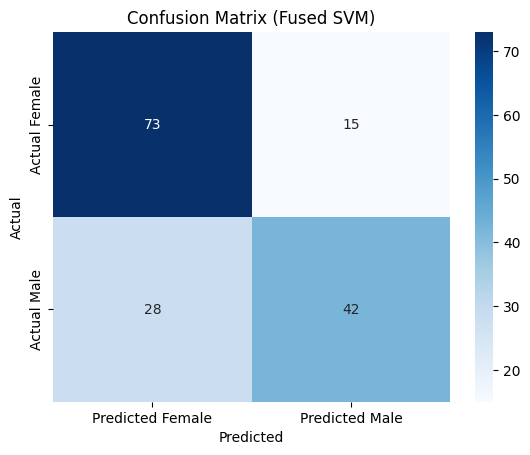


--- Fusion Classification Script Finished ---


In [ ]:
# PHASE 2: Fusing DWI & fMRI and classifying

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC # Using SVM as the fusion classifier
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv" # From Phase 1
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
# SVM parameters for fusion classifier
FUSION_SVM_C = 1.0
FUSION_SVM_GAMMA = 'scale'

# 1. Load Extracted Features
print("Loading extracted DWI and fMRI features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")
except FileNotFoundError as e:
    print(f"Error loading feature file: {e}")
    raise SystemExit("Feature loading failed. Ensure paths are correct.")

# Debugging: Inspect IDs before Merging
print("\n--- ID Inspection ---")
print("DWI SubjectIDs (First 5):")
print(dwi_features_df['SubjectID'].head())
print("\nfMRI SubjectIDs (First 5):")
print(fmri_features_df['SubjectID'].head())

print(f"\nDWI SubjectID Data Type: {dwi_features_df['SubjectID'].dtype}")
print(f"fMRI SubjectID Data Type: {fmri_features_df['SubjectID'].dtype}")

dwi_ids = set(dwi_features_df['SubjectID'].astype(str))
fmri_ids = set(fmri_features_df['SubjectID'].astype(str))

print(f"\nNumber of unique DWI SubjectIDs: {len(dwi_ids)}")
print(f"Number of unique fMRI SubjectIDs: {len(fmri_ids)}")

common_ids = dwi_ids.intersection(fmri_ids)
print(f"\nNumber of common SubjectIDs found: {len(common_ids)}")

if len(common_ids) == 0:
    print("\n*** ERROR: No common SubjectIDs found even after standardization!")
    import sys
    sys.exit("Stopping due to ID mismatch.")
elif len(common_ids) < min(len(dwi_ids), len(fmri_ids)):
     print(f"\nWarning: Found {len(common_ids)} common IDs, which is less than the number of samples in DWI ({len(dwi_ids)}) or fMRI ({len(fmri_ids)}). Some subjects might be missing from one modality.")


# 2. Merge Features based on SubjectID
print("\nMerging features based on SubjectID...")
dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)

# Merge on 'SubjectID'
merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))

# Verify labels match after merge
if 'label_dwi' in merged_df.columns and 'label_fmri' in merged_df.columns:
    if not merged_df['label_dwi'].equals(merged_df['label_fmri']):
        print("Warning: Label mismatch found for some SubjectIDs after merging! Using DWI labels.")
    merged_df['label'] = merged_df['label_dwi']
    merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
elif 'label' in merged_df.columns:
    pass
else:
    raise ValueError("Could not find label column after merging.")

print(f"Merged features shape: {merged_df.shape}")
if merged_df.shape[0] == 0:
    raise SystemExit("Error: No subjects remaining after merging, even with SubjectID.")

# 3. Prepare Data for Classifier
print("Preparing fused data for classification...")
dwi_feature_cols = [col for col in merged_df.columns if col.startswith('dwi_feature_')]
fmri_feature_cols = [col for col in merged_df.columns if col.startswith('fmri_feature_')]
feature_cols = dwi_feature_cols + fmri_feature_cols # Combine feature columns

X_fused = merged_df[feature_cols].values
y_fused = merged_df['label'].values
print(f"Fused X shape: {X_fused.shape}") # (num_common_subjects, #dwi_features + #fmri_features)
print(f"Fused y shape: {y_fused.shape}")
print(f"Fused label distribution: {np.bincount(y_fused)}")

# 4. Train/Test Split for Fused Data
print("Splitting fused data...")
X_train_fused, X_test_fused, y_train_fused, y_test_fused = train_test_split(
    X_fused, y_fused,
    test_size=TEST_SPLIT_RATIO,
    random_state=RANDOM_STATE,
    stratify=y_fused
)

# 5. Scale Fused Features
print("Scaling fused features...")
scaler_fused = StandardScaler()
X_train_fused_scaled = scaler_fused.fit_transform(X_train_fused)
X_test_fused_scaled = scaler_fused.transform(X_test_fused)

# 6. Train Fusion Classifier (SVM)
print("Training SVM classifier on fused features...")
svm_fused_model = SVC(
    C=FUSION_SVM_C, kernel='rbf', gamma=FUSION_SVM_GAMMA,
    probability=True, class_weight='balanced', random_state=RANDOM_STATE
)
svm_fused_model.fit(X_train_fused_scaled, y_train_fused)
print("Fusion SVM training finished.")

# 7. Evaluate Fusion Classifier
print("\nEvaluating fusion model on the test set...")
y_pred_proba_fused = svm_fused_model.predict_proba(X_test_fused_scaled)[:, 1]
y_pred_classes_fused = svm_fused_model.predict(X_test_fused_scaled)

test_accuracy_fused = accuracy_score(y_test_fused, y_pred_classes_fused)
test_auc_fused = roc_auc_score(y_test_fused, y_pred_proba_fused)
test_precision_fused = precision_score(y_test_fused, y_pred_classes_fused, zero_division=0)
test_recall_fused = recall_score(y_test_fused, y_pred_classes_fused, zero_division=0)
test_f1_fused = f1_score(y_test_fused, y_pred_classes_fused, zero_division=0)

print("\nTest Set Performance (Fused SVM Model):")
print(f"  Accuracy:  {test_accuracy_fused:.4f} ({test_accuracy_fused*100:.2f}%)")
print(f"  AUC:       {test_auc_fused:.4f}")
print(f"  Precision: {test_precision_fused:.4f}")
print(f"  Recall:    {test_recall_fused:.4f}")
print(f"  F1-Score:  {test_f1_fused:.4f}")

print("\nClassification Report (Fused SVM Model):")
print(classification_report(y_test_fused, y_pred_classes_fused, target_names=['Female (0)', 'Male (1)'], zero_division=0))

print("\nConfusion Matrix (Fused SVM Model):")
cm_fused = confusion_matrix(y_test_fused, y_pred_classes_fused)
sns.heatmap(cm_fused, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Female', 'Predicted Male'], yticklabels=['Actual Female', 'Actual Male'])
plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.title('Confusion Matrix (Fused SVM)'); plt.show()

print("\n--- Fusion Classification Script Finished ---")

Loading extracted DWI and fMRI features...
DWI features loaded: (787, 130)
fMRI features loaded: (787, 130)
Merging features based on SubjectID...
Merged features shape: (787, 258)
Preparing fused data...
Fused X shape: (787, 256), Fused y shape: (787,)
Splitting fused data...
Scaling fused features...

Performing RFECV feature selection...
Fitting RFECV selector...
Fitting estimator with 256 features.
Fitting estimator with 231 features.
Fitting estimator with 206 features.
Fitting estimator with 181 features.
Fitting estimator with 156 features.
RFECV fitting finished in 5.06 seconds.

Optimal number of features selected by RFECV: 131


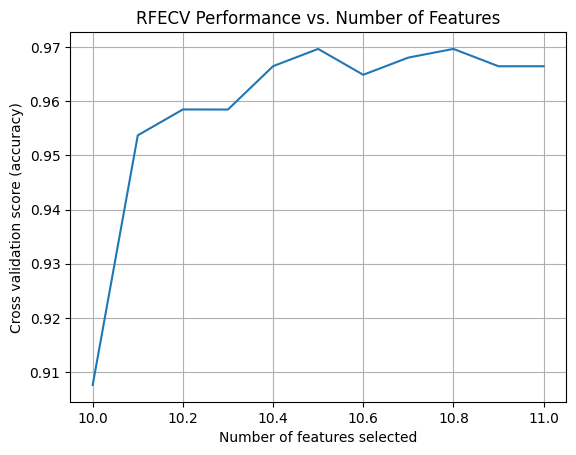

Transforming data to selected features...
Selected Train features shape: (629, 131)
Selected Test features shape: (158, 131)

Training final SVM classifier on SELECTED fused features...
Final SVM training finished.

Evaluating fusion model with SELECTED features on the test set...

Test Set Performance (Fused SVM Model with Feature Selection):
  Accuracy:  0.7215 (72.15%)
  AUC:       0.8167
  Precision: 0.7097
  Recall:    0.6286
  F1-Score:  0.6667

Classification Report (Fused SVM Model with Feature Selection):
              precision    recall  f1-score   support

  Female (0)       0.73      0.80      0.76        88
    Male (1)       0.71      0.63      0.67        70

    accuracy                           0.72       158
   macro avg       0.72      0.71      0.71       158
weighted avg       0.72      0.72      0.72       158


Confusion Matrix (Fused SVM Model with Feature Selection):


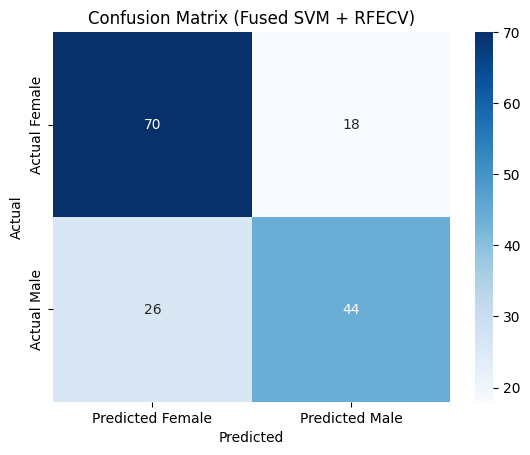


--- Fusion Classification with RFECV Script Finished ---


In [ ]:
# PHASE 2B: fusion with feature selection

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC, LinearSVC # Import LinearSVC for RFECV
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import seaborn as sns
import time # To time feature selection

# Configuration
DWI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/dwi_l2_cnn_extracted_features.csv"
FMRI_FEATURES_PATH = "/content/drive/MyDrive/Colab Notebooks/ML_PROJECT/fmri_gap_cnn_extracted_features.csv"
RANDOM_STATE = 42
TEST_SPLIT_RATIO = 0.2
# RFECV Params
RFECV_STEP = 0.1 # Remove 10% of features each step
RFECV_CV_FOLDS = 5
RFECV_SCORING = 'accuracy'
# Final SVM parameters
FUSION_SVM_C = 1.0
FUSION_SVM_GAMMA = 'scale'

# 1. Load Extracted Features
print("Loading extracted DWI and fMRI features...")
try:
    dwi_features_df = pd.read_csv(DWI_FEATURES_PATH)
    fmri_features_df = pd.read_csv(FMRI_FEATURES_PATH)
    print(f"DWI features loaded: {dwi_features_df.shape}")
    print(f"fMRI features loaded: {fmri_features_df.shape}")
except Exception as e: print(f"Error loading feature file: {e}"); raise SystemExit("Feature loading failed.")

# 2. Merge Features based on SubjectID
print("Merging features based on SubjectID...")
dwi_features_df['SubjectID'] = dwi_features_df['SubjectID'].astype(str)
fmri_features_df['SubjectID'] = fmri_features_df['SubjectID'].astype(str)
merged_df = pd.merge(dwi_features_df, fmri_features_df, on='SubjectID', how='inner', suffixes=('_dwi', '_fmri'))
if 'label_dwi' in merged_df.columns and 'label_fmri' in merged_df.columns:
    if not merged_df['label_dwi'].equals(merged_df['label_fmri']): print("Warning: Label mismatch!")
    merged_df['label'] = merged_df['label_dwi']
    merged_df = merged_df.drop(columns=['label_dwi', 'label_fmri'])
print(f"Merged features shape: {merged_df.shape}")
if merged_df.shape[0] == 0: raise SystemExit("Error: No subjects after merging.")

# 3. Prepare Data
print("Preparing fused data...")
dwi_feature_cols = [col for col in merged_df.columns if col.startswith('dwi_feature_')]
fmri_feature_cols = [col for col in merged_df.columns if col.startswith('fmri_feature_')]
feature_cols = dwi_feature_cols + fmri_feature_cols
X_fused = merged_df[feature_cols].values
y_fused = merged_df['label'].values
print(f"Fused X shape: {X_fused.shape}, Fused y shape: {y_fused.shape}")

# 4. Train/Test Split
print("Splitting fused data...")
X_train_fused, X_test_fused, y_train_fused, y_test_fused = train_test_split(
    X_fused, y_fused, test_size=TEST_SPLIT_RATIO, random_state=RANDOM_STATE, stratify=y_fused)

# 5. Scale Features (Train and Test separately)
print("Scaling fused features...")
scaler_fused = StandardScaler()
X_train_fused_scaled = scaler_fused.fit_transform(X_train_fused)
X_test_fused_scaled = scaler_fused.transform(X_test_fused)

# 6. Perform RFECV Feature Selection (on Training data only)
print("\nPerforming RFECV feature selection...")
# Using a fast linear estimator for ranking features in RFECV
# dual='auto' handles data shape
estimator_for_rfe = LinearSVC(max_iter=2000, class_weight='balanced', dual='auto', random_state=RANDOM_STATE)

# Setup RFECV
cv_strategy = StratifiedKFold(n_splits=RFECV_CV_FOLDS)
selector = RFECV(
    estimator=estimator_for_rfe,
    step=RFECV_STEP,       # Percentage or integer of features to remove per step
    cv=cv_strategy,
    scoring=RFECV_SCORING, # Metric to optimize for selecting number of features
    min_features_to_select=10, # Minimum number of features to keep
    n_jobs=-1,
    verbose=1
)

# Fit RFECV on the training data
start_time = time.time()
print("Fitting RFECV selector...")
selector = selector.fit(X_train_fused_scaled, y_train_fused)
end_time = time.time()
print(f"RFECV fitting finished in {end_time - start_time:.2f} seconds.")

print(f"\nOptimal number of features selected by RFECV: {selector.n_features_}")

# Plot number of features vs. cross-validation scores
try:
    n_scores = len(selector.cv_results_["mean_test_score"])
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel(f"Cross validation score ({RFECV_SCORING})")
    plt.plot(
        np.arange(selector.min_features_to_select, selector.min_features_to_select + n_scores * selector.step, selector.step),
        selector.cv_results_["mean_test_score"],
    )
    plt.title("RFECV Performance vs. Number of Features")
    plt.grid()
    plt.show()
except Exception as plot_err:
      print(f"Could not plot RFECV results: {plot_err}")


# 7. Transform Data using Selected Features
print("Transforming data to selected features...")
X_train_fused_selected = selector.transform(X_train_fused_scaled)
X_test_fused_selected = selector.transform(X_test_fused_scaled)
print(f"Selected Train features shape: {X_train_fused_selected.shape}")
print(f"Selected Test features shape: {X_test_fused_selected.shape}")

# 8. Training Final Classifier (SVM RBF) on Selected Features
print("\nTraining final SVM classifier on SELECTED fused features...")
svm_fused_selected_model = SVC(
    C=FUSION_SVM_C, kernel='rbf', gamma=FUSION_SVM_GAMMA,
    probability=True, class_weight='balanced', random_state=RANDOM_STATE
)
svm_fused_selected_model.fit(X_train_fused_selected, y_train_fused)
print("Final SVM training finished.")

# 9. Evaluating Final Classifier
print("\nEvaluating fusion model with SELECTED features on the test set...")
y_pred_proba_fused_sel = svm_fused_selected_model.predict_proba(X_test_fused_selected)[:, 1]
y_pred_classes_fused_sel = svm_fused_selected_model.predict(X_test_fused_selected)

test_accuracy_fused_sel = accuracy_score(y_test_fused, y_pred_classes_fused_sel)
test_auc_fused_sel = roc_auc_score(y_test_fused, y_pred_proba_fused_sel)
test_precision_fused_sel = precision_score(y_test_fused, y_pred_classes_fused_sel, zero_division=0)
test_recall_fused_sel = recall_score(y_test_fused, y_pred_classes_fused_sel, zero_division=0)
test_f1_fused_sel = f1_score(y_test_fused, y_pred_classes_fused_sel, zero_division=0)

print("\nTest Set Performance (Fused SVM Model with Feature Selection):")
print(f"  Accuracy:  {test_accuracy_fused_sel:.4f} ({test_accuracy_fused_sel*100:.2f}%)")
print(f"  AUC:       {test_auc_fused_sel:.4f}")
print(f"  Precision: {test_precision_fused_sel:.4f}")
print(f"  Recall:    {test_recall_fused_sel:.4f}")
print(f"  F1-Score:  {test_f1_fused_sel:.4f}")

print("\nClassification Report (Fused SVM Model with Feature Selection):")
print(classification_report(y_test_fused, y_pred_classes_fused_sel, target_names=['Female (0)', 'Male (1)'], zero_division=0))

print("\nConfusion Matrix (Fused SVM Model with Feature Selection):")
cm_fused_sel = confusion_matrix(y_test_fused, y_pred_classes_fused_sel)
sns.heatmap(cm_fused_sel, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Female', 'Predicted Male'], yticklabels=['Actual Female', 'Actual Male'])
plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.title('Confusion Matrix (Fused SVM + RFECV)'); plt.show()

print("\n--- Fusion Classification with RFECV Script Finished ---")